# SLT-CE-4: Histogram Clustering

<h2 style="background-color:#f0b375;"> References </h2>

<ol>
<li> Histogram clustering for unsupervised image segmentation http://ieeexplore.ieee.org/document/784981/
</li>

<li> Lecture Slides 4 https://ml2.inf.ethz.ch/courses/slt/lectures/slt18_lecture04.pdf
</li>
</ol>

<h2 style="background-color:#f0b375;"> Setup </h2>

In [2]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread

## Texture and label map

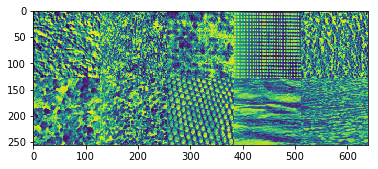

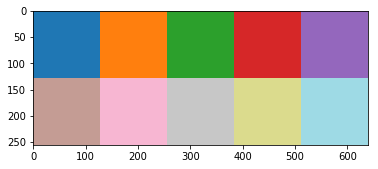

In [4]:
texture = imread("texture.png")

patch_grid_shape = (2,5)
patch_shape = (128,128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i : patch_shape[0] * (i + 1), \
              patch_shape[1] * j : patch_shape[1] * (j + 1)] = np.ravel_multi_index((i,j), patch_grid_shape)
    # print("i: "+ str(i)+ "; j: "+ str(j))
    
plt.imshow(texture)
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.show()

## Permuted texture and label map

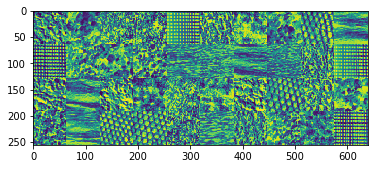

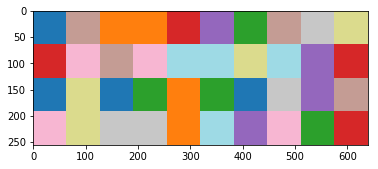

In [23]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i//2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape)
    
    perm_texture[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                 jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    texture[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
            j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
    
    perm_label_map[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                   jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    label_map[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
              j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
  
plt.imshow(perm_texture)
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.show()

<h2 style="background-color:#f0b375;">
Problem 0<br>
<span style=font-size:50%> Complete all Problems to get the grade "1" </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both, Maximum a Posteriori estimation and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference [1] looks for the case of DA (using the notation of reference [1]). Hint: Take a look at the lecture slides, too.
</p>

#### Maximum a Posteriori estimation
The probability distribution for a object (patch) reads as:  <br>
$\hat{P}(x) = \frac{n(x)}{\sum_{x' \in X} n(x')}$ <br>
The equivalent to the centroid condition in k-means reads as: <br>
$\hat{P} (y|c) = \sum_{x: \hat{c}(x) = c} \frac{n(x)}{\sum_{x': \hat{c}(x') = c} n(x')} \hat{P} (y|x)$ <br>
for a particular cluster $c$, one sums over the features (distribution) of the objects (patches) assigned to this cluster ($\hat{c}(x) = c$) weighted by the number of observations in the corresponding patch. <br>
The anologon to the nearest neighbor rule reads as: <br>
$\hat{c}(x) = argmin_a \big(- \sum_{y \in Y} \hat{P} (y|x) log \hat{P}(y|a)- log P(\hat{c}_a^x) \big)$ <br>
for a particular $x$, one searches for the cluster assignment, which maximizes the sum over all features of the empirical histogram of the patch $\hat{P} (y|x)$ times the logarithm of histogram of the cluster $\hat{P}(y|a)$ (to be optimized). Additionally, if there would be some knowledge about the prior $P(\hat{c}_a^x)$, e.g. topological preferences, one could include this as well.

#### Deterministic Annealing
Following equation corresponds to the computation of posterior probabilities in the E-step: <br>
$P\big(c(x) = a| \hat{\theta} \big) = \frac{exp\big(-h(a,x; \hat{\theta})/T \big)}{\sum_{b=1}^K exp \big(-h(b,x; \hat{\theta})/T \big)}$ <br>
where <br>
$h(a, x; \hat{\theta}) = n(x) D_\text{KL} \big[ \hat{P}(\cdot| x) || \hat{P}(\cdot | a) \big]$ <br>
Here, the similarity of the feature distribution for patch $x$ and the feature distribution for cluster $a$ is measured by the cross-entropy Kullback-Leibler divergence. By temperature scheduling, one tries to escape local minima. 

In the case of DA, equation (5) becomes <br> $\hat{P}(y|c)= \frac{\sum_{x \in X} \hat{P}(\cdot|x) P(\cdot| c(x))}{\sum_{x \in X} P(\cdot| c(x))}$ <br>


<h2 style="background-color:#f0b375;"> Problem 1 </h2>

<p style="background-color:#adebad;">
    Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring.
    You can add more class methods if necessary.
</p>

In [6]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=64, window_size=15, random_state=42, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins = n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        # Add more parameters, if necessary.
        
        
    def plot_clustering(self, original, reconstructed):
        
        plt.figure()
        plt.imshow(original, cmap="tab20")
        plt.figure()
        plt.imshow(reconstructed, cmap="tab20")
        plt.show()
        
        pass
        
    
    def fit(self, X):
        """Compute HC for input image X
        
        Compute centroids.        
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            self
        """
        
        # self
        estimation = self.estimation
        n_clusters = self.n_clusters
        n_bins = self.n_bins
        ws = self.window_size
        
        _, self.bin_edges = np.histogram(X, self.n_bins)
        bin_edges = self.bin_edges
        
        # number of windows in each direction
        no_x = X.shape[1]
        no_y = X.shape[0]
        
        # n(x) - number of observations for object x
        nx = np.ones([no_y, no_x])
        
        # P_hat(y | x) -> feature distribution for given x      
        p_y_x = np.zeros([no_y, no_x, n_bins])
        
        
        for j in range(no_y):
            for i in range(no_x):
                i1 = np.max([i- int(ws/2), 0])
                i2 = np.min([i+ int(ws/2)+ 1, no_x])
                j1 = np.max([j- int(ws/2), 0])
                j2 = np.min([j+ int(ws/2)+ 1, no_y])
                
                p_y_x[j, i], _ = np.histogram(X[j1: j2, i1: i2], self.bin_edges)
        
        nx = np.sum(p_y_x, axis = 2)
        
        for j in range(no_y):
            for i in range(no_x):
                p_y_x[j, i] /= nx[j, i]
            
        # ------------------------------------------------------------------------------------------
        if estimation == "MAP":
            
            # P_hat(y|c) - a posteriori (initially all clusters look the same) XXXXX
            p_y_c = 1/ n_bins* np.ones([n_bins, n_clusters])
            
            # c_hat(x) - to which centroid each x belongs to XXXXX
            c_hat = np.random.randint(n_clusters, size= (no_y, no_x)) #np.zeros([no_y, no_x])
            
            # alternating maximization
            # while np.any(eps > tol):
            for l in range(100):
                c_hat_old = c_hat.copy()
                p_y_c_old = p_y_c.copy()
                
                
                # ---------------------------- centroid condition ------------------------------
                # loop over clusters (c)
                
                for c in range(n_clusters):
                    
                    j, i = np.where(c_hat == c)
                    pyc = np.dot(nx[j, i], p_y_x[j, i])
                    nxc = np.sum(nx[j, i])
                    
                    if nxc != 0:
                        p_y_c[:, c] = pyc/ nxc
                        
                    else:
                        p_y_c[:, c] = 1/ n_bins* np.ones([n_bins]) 
                    
                p_y_c[np.where(p_y_c== 0)] = 1E-5
                
                # ---------------------------- "nearest neighbor" -----------------------------
                c_hat = np.argmin(- np.dot(p_y_x, np.log(p_y_c)), axis = 2)
                  
        
        elif estimation == "DA":
            
            print("later")
            # Code for Deterministic Annealing estimation
            
        self.centroids = p_y_c
        
        test_img = np.zeros([no_y, no_x])
        for j in range(no_y):
            for i in range(no_x):
                test_img[j, i] = c_hat[j, i]
        
        plt.figure()
        plt.imshow(test_img, cmap= "tab20")
        plt.show()
        
        return self
    
    
    
    def predict(self, X):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        check_is_fitted(self, ["centroids"])
        
        # self
        n_clusters = self.n_clusters
        n_bins = self.n_bins
        ws = self.window_size
        bin_edges = self.bin_edges
        p_y_c = self.centroids
        
        # number of windows in each direction
        no_x = X.shape[1]
        no_y = X.shape[0]
        
        # n(x) - number of observations for object x
        nx = np.ones([no_y, no_x])
        
        # P_hat(y | x) -> feature distribution for given x      
        p_y_x = np.zeros([no_y, no_x, n_bins])
        
        # loop over y dimension
        for j in range(no_y):
            # loop over x dimension
            for i in range(no_x):
                i1 = np.max([i- int(ws/2), 0])
                i2 = np.min([i+ int(ws/2)+ 1, no_x])
                j1 = np.max([j- int(ws/2), 0])
                j2 = np.min([j+ int(ws/2)+ 1, no_y])
                
                p_y_x[j, i], _ = np.histogram(X[j1: j2, i1: i2], bin_edges)
        
        nx = np.sum(p_y_x, axis = 2)
        
        for j in range(no_y):
            for i in range(no_x):
                p_y_x[j, i] /= nx[j, i]
        
        # find minimum -> cluster assignment
        C = np.argmin(- np.dot(p_y_x, np.log(p_y_c)), axis = 2)

        return C
    
    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])
        
        # probability
        p_y_c = self.centroids
        
        # determine center of bins
        bin_edges = self.bin_edges
        bins = np.zeros([self.n_bins])

        for i in range(self.n_bins):
            bins[i] = (bin_edges[i+1]+ bin_edges[i])/ 2

        # initialize array
        X = np.zeros([C.shape[0], C.shape[1]])
               
        
        # loop over image
        for j in range(C.shape[0]):
            for i in range(C.shape[1]):
                # make sure that probabilitie sum to 1
                p_y_c[:, int(C[j, i])] /= np.sum(p_y_c[:, int(C[j, i])])
                
                # draw from distribution
                X[j, i] = np.random.choice(bins, p = p_y_c[:, int(C[j, i])])
        
        return X


<p style="background-color:#adebad;">
    Create an instance of your HC class with n_clusters = 8 and fit the image texture. Record the execution time.
</p>

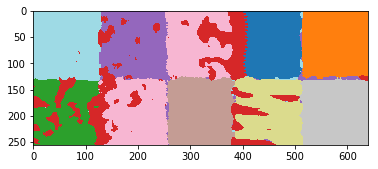

Wall time: 51.9 s


In [7]:
%%time
HC = HistogramClustering()
HC.fit(texture)

 <h2 style="background-color:#f0b375;"> Problem 2 </h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>

        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>

    </ul>
</p>

In [9]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

Wall time: 20.9 s


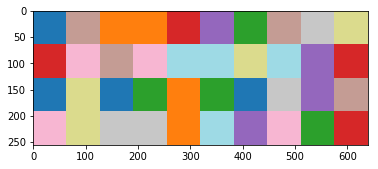

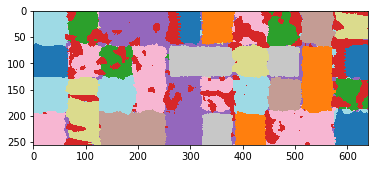

In [11]:
 # Plot of predicted label map
HC.plot_clustering(perm_label_map, predicted_perm_label_map)

 <p style="background-color:#adebad;">
    Compute the accuracy of the prediction for each texture, using the perm_label_map. Make sure to permute the texture labels appropriately, so that they are in correpondence with the true labels. Plot the accuracies in a bar plot (x-axis: texture id, y-axis: accuracy).
</p>

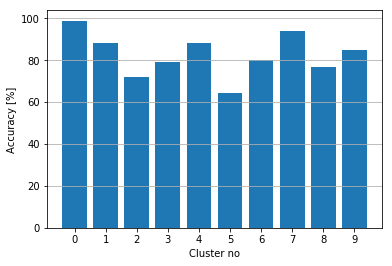

In [31]:
def accuracy(perm_label_map, predicted_perm_label_map, patch_grid_shape):
    cluster_dummy = np.arange(0, np.prod(patch_grid_shape))
    cluster_assigned = np.empty([np.prod(patch_grid_shape)])

    acc_dummy = np.zeros([np.prod(patch_grid_shape)])
    acc_assigned = np.zeros([np.prod(patch_grid_shape)])

    
    for c in range(np.prod(patch_grid_shape)):

        # extract location of given cluster in original image
        j, i = np.where(perm_label_map == c)  

        # find assignments in predicted image based on location of cluster
        a_predicted = predicted_perm_label_map[j, i]

        # histogram over assignments 
        a_hist, _ = np.histogram(a_predicted, bins = np.prod(patch_grid_shape))

        acc_assigned[c] = np.max(a_hist)/ np.sum(a_hist)

    '''
    
    # It might happen that predicted clusters are mis-assigned, and hence multiple predicted clusters
    # map to the same true cluster
    # To take this into account, in each loop the mapping predicted_cluster <-> true_cluster with the highest 
    # accuracy is assigned. The true cluster will be deleted from the list of possible clusters and the procedure
    # is repeated until all predicted clusters are assigned uniquely to a real cluster
    
    # loop over total number of clusters
    for it in range(np.prod(patch_grid_shape)):
        
        # loop over not yet assigned clusters
        for c in cluster_dummy:

            # extract location of given cluster in original image
            j, i = np.where(perm_label_map == c)  

            # find assignments in predicted image based on location of cluster
            a_predicted = predicted_perm_label_map[j, i]

            # histogram over assignments 
            a_hist, _ = np.histogram(a_predicted, bins = np.prod(patch_grid_shape))

            # accuracy -------------------------------
            # find cluster with maximum agreement
            a_argmax = np.argmax(a_hist)

            # if this cluster is already assigned -> look for second closest agreement etc.
            flag = 1
            
            while a_argmax in cluster_assigned:
                flag+= 1
                a_sort = a_hist.flatten()
                a_sort.sort()

                a_argmax = np.where(a_hist == a_sort[-flag])[0][0]

            # c <-> a_argmax    
                            
            # accuracy of cluster assignment
            acc_dummy[c] = a_hist[a_argmax]/ np.sum(a_hist)
            

        # cluster number in predicted space
        c_idx = np.argmax(acc_dummy)
        
        cluster_assigned[c_idx] = c_idx
        
        print(cluster_assigned)
        
        acc_assigned[c_idx] = acc_dummy[c_idx]

        acc_dummy[c_idx] = 0

        cluster_dummy = np.delete(cluster_dummy, np.where(cluster_dummy == c_idx))
    '''
        
    return cluster_assigned, acc_assigned
    

cluster_assigned, acc_assigned = accuracy(perm_label_map, predicted_perm_label_map, patch_grid_shape)

cluster_dummy = np.arange(0, np.prod(patch_grid_shape))

plt.figure()
# plt.bar(cluster_assigned, acc_assigned* 10)
plt.bar(cluster_dummy, acc_assigned* 100)
plt.xlabel('Cluster no')
plt.ylabel('Accuracy [%]')
plt.xticks(cluster_dummy)
plt.grid(axis = 'y')
plt.show()
   


 <h2 style="background-color:#f0b375;"> Problem 3 </h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the result.
        </li>

    </ul>

C:\Users\engel\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


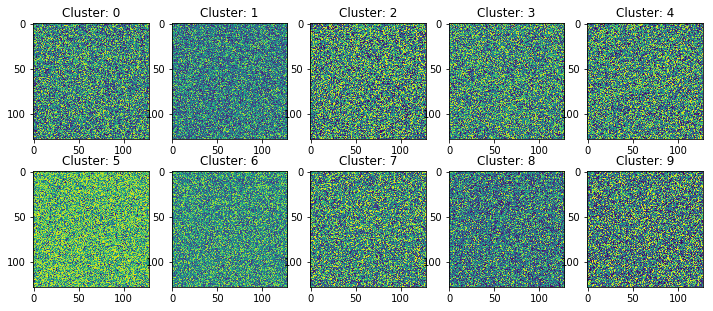

In [212]:
C1 = np.ones(patch_shape)
X1 = HC.generate(C1)

fig, ax = plt.subplots(patch_grid_shape[0], patch_grid_shape[1], figsize=(12, 7))

for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    C = patch* np.ones(patch_shape)
    X = HC.generate(C)
    ax[i, j].imshow(X)
    ax[i, j].set_title('Cluster: '+ str(patch))
    
fig.show()

# C2, C3, etc. You can also use a more suitable data structure to loop over the textures.

In [ ]:
##it could have been useful to also plot a real patch of each relative cluster

<h2 style="background-color:#f0b375;"> Problem 4 </h2>

<p style="background-color:#adebad;">
    Using n_clusters=8, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix, and label the axes properly.
</p>

Bins: 16, Window_size: 7


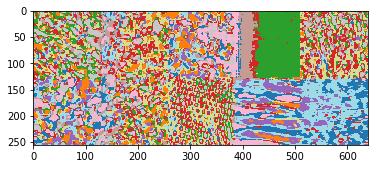

Bins: 16, Window_size: 9


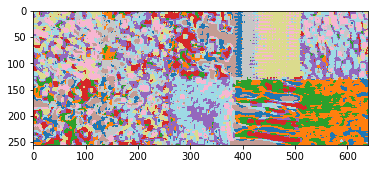

Bins: 16, Window_size: 11


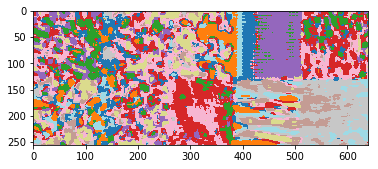

Bins: 32, Window_size: 7


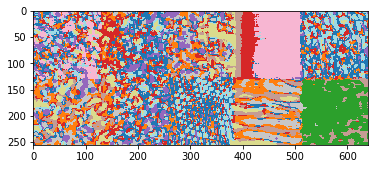

Bins: 32, Window_size: 9


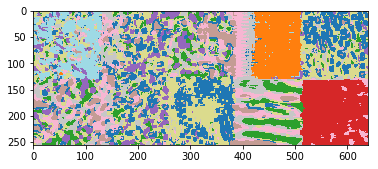

Bins: 32, Window_size: 11


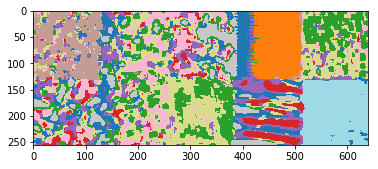

Bins: 64, Window_size: 7


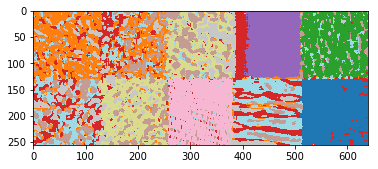

Bins: 64, Window_size: 9


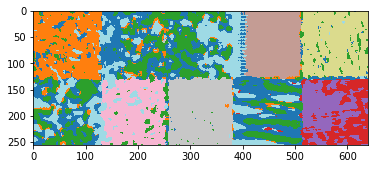

Bins: 64, Window_size: 11


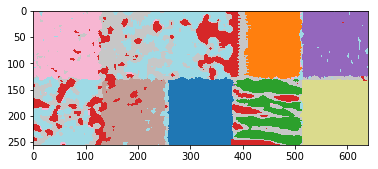

In [257]:
n_bins = np.array([16, 32, 64])
window_size = np.array([7, 9, 11])

acc_assigned = np.zeros([len(n_bins), len(window_size)], dtype = object)

HC = []

for i, nb in enumerate(n_bins):
    for j, ws in enumerate(window_size):
        idx = j+ i* len(window_size)
        
        print('Bins: '+ str(n_bins[i])+ ', Window_size: '+ str(window_size[j]))

        HC.append(HistogramClustering(n_bins = nb, window_size = ws))
        HC[idx].fit(texture)
        predicted_perm_label_map = HC[idx].predict(perm_texture)
        
        cluster_assigned, acc_assigned[i, j] = accuracy(perm_label_map, predicted_perm_label_map, patch_grid_shape)
        



<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture itself. Arrange the plots next to each other in a grid and label them properly.
    </p>

C:\Users\engel\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


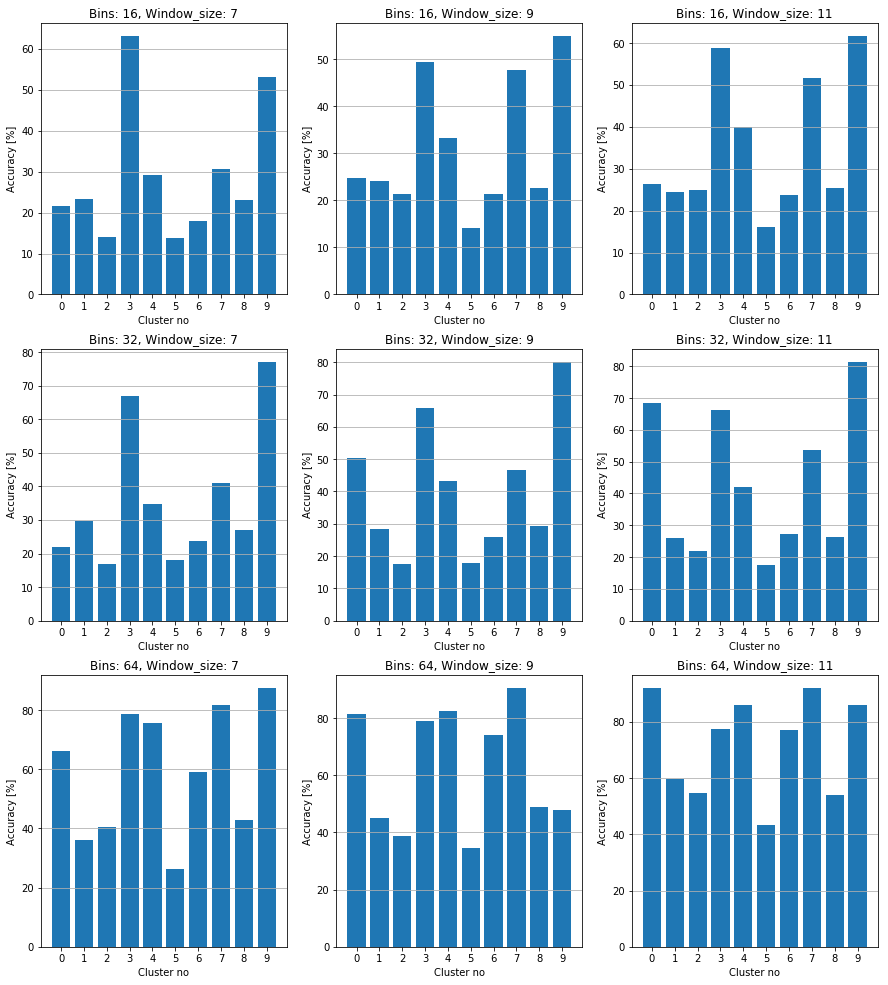

In [262]:
cluster_dummy = np.zeros([np.prod(patch_grid_shape)])

fig, ax = plt.subplots(len(n_bins), len(window_size), figsize=(15, 17))

for i, nb in enumerate(n_bins):
    for j, ws in enumerate(window_size):
        ax[i, j].bar(cluster_dummy, acc_assigned[i, j]* 100)
        ax[i, j].set_title('Bins: '+ str(n_bins[i])+ ', Window_size: '+ str(window_size[j]))
        ax[i, j].set_xlabel('Cluster no')
        ax[i, j].set_ylabel('Accuracy [%]')
        ax[i, j].set_xticks(cluster)
        ax[i, j].grid(axis = 'y')
    
fig.show()

    

In [ ]:
##you could have use also a summuary measure (like average accuracy over all clusters) to have something that you
##can grasp more easily

<h2 style="background-color:#ef7575;">
Extension 1  
<span style=font-size:50%> Complete all Extensions to get the grade "2" </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        Plot the clustering of the texture at different temperatures.
        </li>
    </ul>

<h2 style="background-color:#ef7575;"> Extension 2 </h2>

<ul style="background-color:#adebad;">
    <li>
        Use kmeans clustering to cluster the pixels of the texture. Set n_clusters=8, and use the local histogram vectors as features (with the best settings for n_bins and window_size that you found in problem 4).
    </li>
</ul>

<ul style="background-color:#adebad;">
    <li>
        Compute the accuracy of the kmeans prediction of perm_texture and compare it to the HC result.
    </li>
</ul>

<h2 style="background-color:#ef7575;"> Extension 3 </h2>

<ul style="background-color:#adebad;">
        <li>
        Plot the centroid histograms after fitting the texture image with the best parameter settings obtained in problem 4. Relate them to the textures by plotting the corresponding texture patch next to each histogram.
        </li>
    </ul>

<h2 style="background-color:#4286f4;"> Comments </h2>

Let us know what you liked about this exercise, and what we can improve!